In [38]:
# Import helps
from src.helpers import *
from src.plots import *

# Import base
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split

# Feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from umap import UMAP
from sklearn.pipeline import Pipeline

# tensorflow
import tensorflow as tf

pd.options.display.max_rows = 999

# Set seeds for reproducibility
set_seeds()

In [39]:
# class weight function
def cwts(y):
    c0, c1 = np.bincount(y)
    w0=(1/c0)*(len(y))/2 
    w1=(1/c1)*(len(y))/2 
    return {0: w0, 1: w1}

In [40]:
weights = {0: 0.5942162615255658, 1: 3.15346975088968}

In [41]:
tf.keras.backend.clear_session()

In [42]:
# Reload the saved scaled data
X_train = pd.read_csv('data/train/scaled_X_train.csv', parse_dates=True, index_col='unix')
y_train = pd.read_csv('data/train/y_train.csv', parse_dates=True, index_col='unix')
X_test = pd.read_csv('data/test/scaled_X_test.csv', parse_dates=True, index_col='unix')
y_test = pd.read_csv('data/test/y_test.csv', parse_dates=True, index_col='unix')
X_val = pd.read_csv('data/val/scaled_X_val.csv', parse_dates=True, index_col='unix')
y_val = pd.read_csv('data/val/y_val.csv', parse_dates=True, index_col='unix')

In [43]:
y = pd.concat([y_train, y_val, y_test])
y.values.flatten()
weights = cwts(y.values.flatten())

In [44]:
rf = RandomForestClassifier(n_jobs=-1, class_weight=weights)
vif = VIFTransform()
boruta = BorutaPy(rf, n_estimators='auto', verbose=2)
umap = UMAP(n_neighbors=5)
corr = RemoveCorPairwiseTransform()
pipe_1 = Pipeline([('pairwisecor', corr), ('boruta', boruta)], verbose=True)

In [45]:
X_train = pipe_1.fit_transform(X_train, y_train.values.ravel())
X_val = pipe_1.transform(X_val)
X_test = pipe_1.transform(X_test)

[Pipeline] ....... (step 1 of 2) Processing pairwisecor, total=   6.9s
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	201
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	201
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	201
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	201
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	201
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	201
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	201
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	170
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	21
Rejected: 	170
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	21
Rejected: 	170
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	21
Rejected: 	170
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	15
Rejected: 	176
Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	15
Rejected: 	176
Iteration: 	14 / 100
Confirmed: 	10
Tentative: 	15
Rejected: 	176
Iteration: 	15 / 100
Confirme

In [46]:
# Reshape the data into the correct format
seqlen = 1
featurelen = X_train.shape[-1]
train_tensors = tf.keras.utils.timeseries_dataset_from_array(X_train, y_train, seqlen)
val_tensors = tf.keras.utils.timeseries_dataset_from_array(X_val, y_val, seqlen)
test_tensors = tf.keras.utils.timeseries_dataset_from_array(X_test, y_test, seqlen)

In [47]:
# Baseline model
inputs = tf.keras.Input(shape=(seqlen, featurelen))
x = tf.keras.layers.LSTM(36)(inputs)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [48]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 14)]           0         
                                                                 
 lstm (LSTM)                 (None, 36)                7344      
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 7381 (28.83 KB)
Trainable params: 7381 (28.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5)]

model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(x=train_tensors, epochs=100, validation_data=val_tensors,
                    class_weight=weights, callbacks=callbacks)

Epoch 1/100


223/223 [==============================] - 2s 5ms/step - loss: 0.6574 - accuracy: 0.6214 - precision: 0.3332 - recall: 0.7489 - val_loss: 0.8166 - val_accuracy: 0.4485 - val_precision: 0.2808 - val_recall: 0.9112
Epoch 2/100
223/223 [==============================] - 1s 4ms/step - loss: 0.6142 - accuracy: 0.6828 - precision: 0.3773 - recall: 0.7160 - val_loss: 0.8109 - val_accuracy: 0.4827 - val_precision: 0.2914 - val_recall: 0.8881
Epoch 3/100
223/223 [==============================] - 1s 4ms/step - loss: 0.6056 - accuracy: 0.6804 - precision: 0.3768 - recall: 0.7300 - val_loss: 0.7966 - val_accuracy: 0.4945 - val_precision: 0.2949 - val_recall: 0.8775
Epoch 4/100
223/223 [==============================] - 1s 4ms/step - loss: 0.6022 - accuracy: 0.6812 - precision: 0.3789 - recall: 0.7405 - val_loss: 0.8035 - val_accuracy: 0.4926 - val_precision: 0.2945 - val_recall: 0.8803
Epoch 5/100
223/223 [==============================] - 1s 4ms/step - loss: 0.5999 - accuracy: 0.6809 - precision

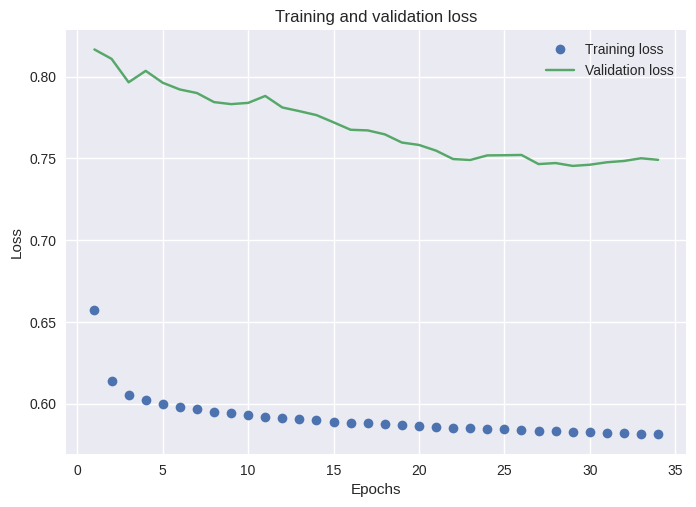

In [50]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plot_metrics(loss_values, val_loss_values, 'loss')

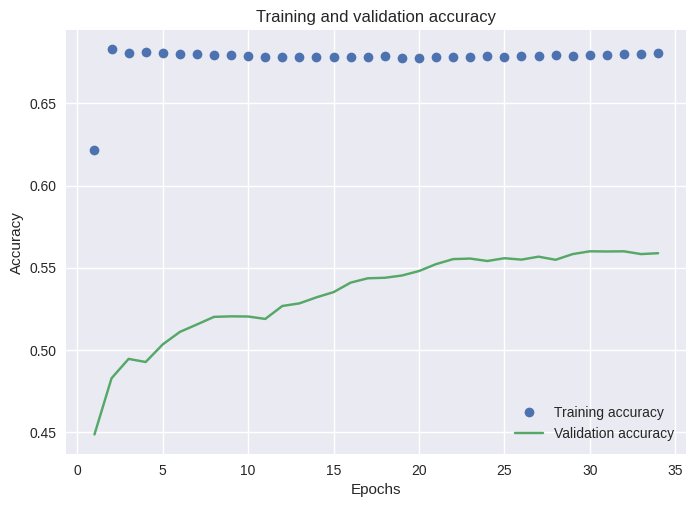

In [51]:
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
plot_metrics(accuracy_values, val_accuracy_values, 'accuracy')

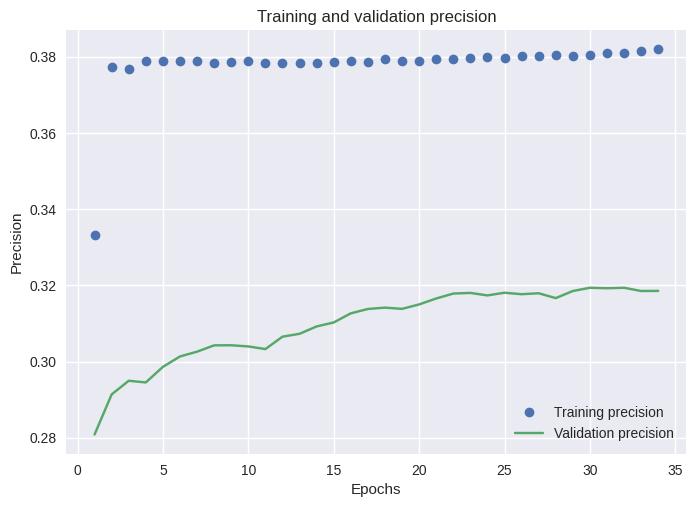

In [52]:
precision_values = history_dict['precision']
val_precision_values = history_dict['val_precision']
plot_metrics(precision_values, val_precision_values, 'precision')

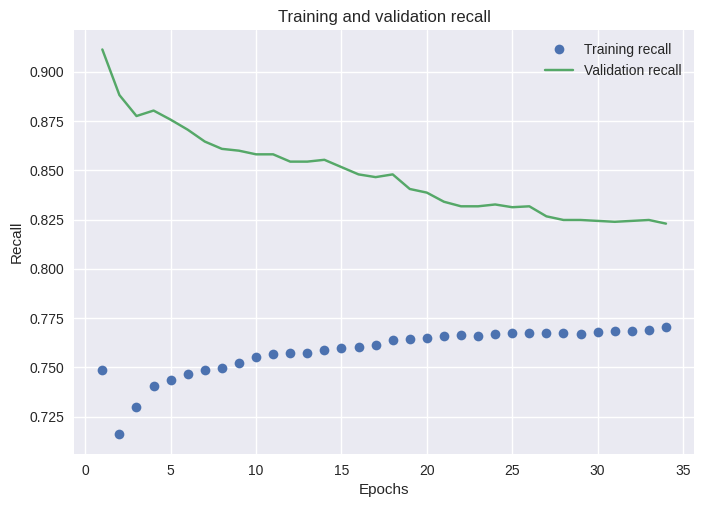

In [53]:
recall_values = history_dict['recall']
val_recall_values = history_dict['val_recall']
plot_metrics(recall_values, val_recall_values, 'recall')

In [54]:
y_pred = np.where(model.predict(test_tensors) > 0.5, 1, 0)

99/99 [==============================] - 0s 2ms/step


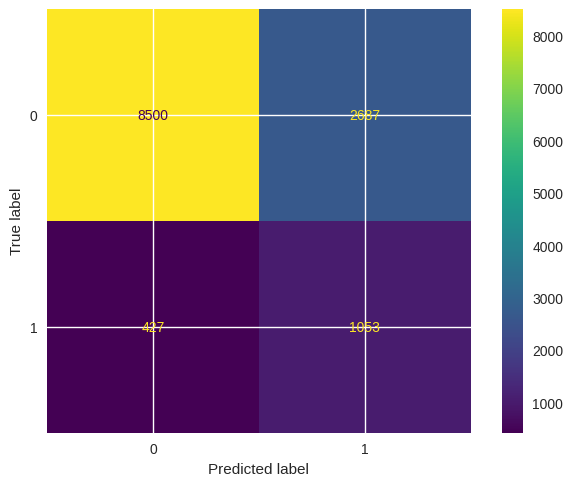

In [55]:
# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report

cm = confusion_matrix(y_test.values, y_pred.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

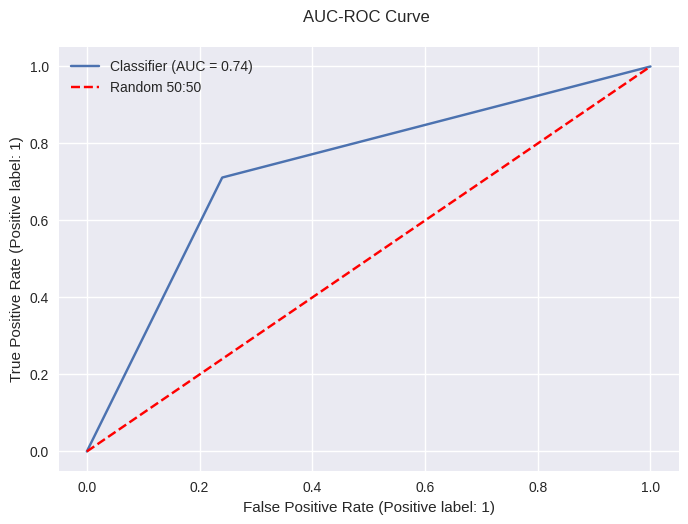

In [56]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title("AUC-ROC Curve \n")
plt.plot([0, 1], [0, 1], linestyle="--", label='Random 50:50', color='r')
plt.legend()
plt.show()

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.76      0.85     11187
           1       0.28      0.71      0.40      1480

    accuracy                           0.75     12667
   macro avg       0.62      0.74      0.62     12667
weighted avg       0.87      0.75      0.79     12667

